In [2]:
# Basics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# ML
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
# Generate requirements.txt
packages = {
    'pandas': pd.__version__,
    'numpy': np.__version__,
    'matplotlib': matplotlib.__version__,
    'seaborn': sns.__version__,
    'yfinance': yf.__version__,
    'scikit-learn': sklearn.__version__
}

with open("requirements.txt", "w") as f:
    for pkg, ver in packages.items():
        f.write(f"{pkg}=={ver}\n")

Seek ML algo to predict the direction of the next day’s return of MSFT adjusted closing price.

In [4]:
params = {
    'tickers':['MSFT','^VIX','SPY','XLK'],
    'start':'2022-01-03',
    'end':'2025-01-03', # ending later so we can get the target for '2024-12-31
    'auto_adjust':False,
    'progress':False
}

raw_data = yf.download(**params)
raw_data = raw_data.ffill()

assert raw_data.isna().sum().sum() == 0, 'exists NA' # Throw error if missing data exists

In [5]:
tickers = params['tickers']
engineered_dict = {f'{ticker}_logreturns':[] for ticker in tickers}
for ticker in tickers:
    adj = raw_data.loc[:,('Adj Close',ticker)]
    log_returns = np.log(adj) - np.log(adj.shift(1))
    log_returns_vals = list(log_returns.values)
    engineered_dict[str(f'{ticker}_logreturns')].extend(log_returns)

    if ticker in ['MSFT']:
        ewma = log_returns.ewm(alpha=0.1, adjust=False).mean()
        engineered_dict[f'{ticker}_ewm'] = ewma

df = pd.DataFrame(engineered_dict, index=raw_data.index).dropna() # Drop NA

# Targets -> {1:'next day positive returns', -1:'next day negative returns'}
shifted = df['MSFT_logreturns'].shift(-1)
df['Target'] = shifted.apply(lambda x: 1 if pd.notna(x) and x > 0 else (-1 if pd.notna(x) else np.nan))
df = df.dropna()

In [6]:
# (X_tr, y_tr), (X_ts, y_ts)
split = {'prop_tr':0.90,'prop_ts':0.10}
assert abs(sum(split.values()) - 1.0) < 1e-8, "Split proportions must sum to 1.0"

n,p = df.shape
n_tr = int(np.ceil(n*split['prop_tr']))

X = df.drop(columns='Target')
y = df['Target']

X_tr, y_tr = X.iloc[:n_tr].to_numpy(), y.iloc[:n_tr].to_numpy()
X_ts, y_ts = X.iloc[n_tr:].to_numpy(), y.iloc[n_tr:].to_numpy()


scaler = StandardScaler() # Scale features
X_tr_scaled = scaler.fit_transform(X_tr)
X_ts_scaled = scaler.transform(X_ts)

In [7]:
# Fit SVM w/o hyperparameter tuning
params = {
    'kernel':'rbf', 
    'gamma':1, 
    'C':1
}

n_splits=5 # Adjust as necessary

svm_model = SVC(**params)
cv = TimeSeriesSplit(n_splits=n_splits)
accuracy_dict = {f'split_{i}':[] for i in range(n_splits)}
for index, (tr_idx, val_idx) in enumerate(cv.split(X_tr_scaled)):
    fit = svm_model.fit(X_tr_scaled[tr_idx], y_tr[tr_idx])
    y_pred = fit.predict(X_tr_scaled[val_idx])
    accuracy = accuracy_score(y_pred=y_pred,y_true=y_tr[val_idx])
    accuracy_dict[f'split_{index}'] = accuracy

avg_accuracy = np.mean(list(accuracy_dict.values()))

print(f"""The average accuracy across {n_splits} folds = {avg_accuracy*100:.2f}%
This slightly underperforms a random selection (50%) - hyperparameter tuning is required.""")

The average accuracy across 5 folds = 49.46%
This slightly underperforms a random selection (50%) - hyperparameter tuning is required.


In [8]:
# Hyperparameter Tuning
param_grid = {
    'C':[0.1,1.0,10,100],
    'gamma':[0.1,0.2,0.3,0.4,0.5,1,5,10]
}

svm_model = SVC()
cv = TimeSeriesSplit(n_splits=5)
model = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=cv, n_jobs=-1).fit(X=X_tr_scaled,y=y_tr)
best_params = model.best_estimator_.get_params()

best_params_subset = {key:best_params[key] for key in param_grid.keys()}
best_accuracy = model.best_score_

print(f"""The best params were {best_params_subset}.
The best accuracy in this grid of params = {best_accuracy*100:.2f}% - we see slight improvements.""")

The best params were {'C': 10, 'gamma': 0.2}.
The best accuracy in this grid of params = 51.43% - we see slight improvements.


### Test Model


**Strategy Assumptions**: 
>We execute one trade per day at market open based on the predicted return: buy fully if the signal is positive, sell fully if negative. Trades are frictionless (no costs), fractional shares are allowed, and execution is at the previous day’s close. Cash earns no interest.

**Trading Strategy Logic**

Starting at the market close of September 13th, 2024, we observe the predicted signal for the next day's return.

- If the predicted signal is buy (1) and we're not currently holding the asset, we invest the full capital at the market open the next day.
- If the predicted signal is sell (-1) and we are currently invested, we sell all holdings at the market open the next day.
- Otherwise, we maintain our current position (either holding cash or staying fully invested).

This strategy continues through the end of the backtesting period, allowing only all-in or all-out positions, no partial trades, and assumes:
- No transaction costs
- Fractional shares allowed
- Execution occurs at next day’s open price
- Cash earns no interest

**Example**:
If the predicted signals over 6 days are:  
`[-1, 1, 1, -1, -1, 1]`  

Then the trade actions are:  
- Day 1: do nothing  
- Day 2: buy all-in  
- Day 3: hold  
- Day 4: sell all  
- Day 5: do nothing  
- Day 6: buy all-in


In [9]:
eval_params = {
    'initial_capital':10e4,
    'ticker':'MSFT'
}

tuned_model = svm_model = SVC(**best_params).fit(X_tr_scaled,y_tr)
y_pred = list(tuned_model.predict(X_ts_scaled))

test_range = list(y.index)[n_tr].strftime('%Y-%m-%d'), list(y.index)[-1].strftime('%Y-%m-%d')
signals = pd.Series(y_pred, index=df.loc[test_range[0]:test_range[1],:].index)
print(f"Evaluate the model on test set range: {test_range[0]} to {test_range[1]}.\n")

stock_prices_plus_one = raw_data['Adj Close'][eval_params['ticker']].iloc[n_tr:]
previous_close = stock_prices_plus_one.shift(1).dropna()

Evaluate the model on test set range: 2024-09-16 to 2024-12-31.



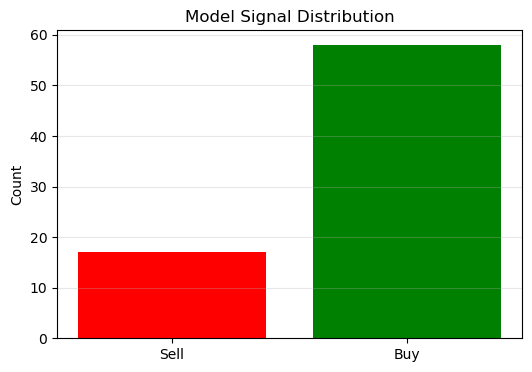

In [10]:
labels_raw, counts = np.unique(y_pred, return_counts=True)
label_map = {-1.0: 'Sell', 1.0: 'Buy'}
labels = [label_map[val] for val in labels_raw]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['red', 'green'])
plt.title('Model Signal Distribution')
plt.ylabel('Count')
plt.grid(axis='y', alpha = 0.3)
plt.savefig('media/signal_distribution')
plt.show()

In [11]:
# Model PnL Calculation
initial = eval_params['initial_capital']
PnL = []
cash = initial
shares = 0
position = 0

for date, signal in signals.items():
    date = date.strftime('%Y-%m-%d')
    price = previous_close[date]
    if position == 0 and signal == 1.0: # No shares & BUY -> BUY
        shares = cash / price
        cash = 0
        position = 1

    elif position == 1 and signal == -1.0: # Holding shares & SELL -> SELL
        cash = price*shares
        shares = 0
        position = 0

    else: # (No shares & SELL) | (Holding shares & BUY) -> No action
        pass

    current_value = cash + shares * price
    PnL.append((date, current_value))

pnl_df = pd.DataFrame(PnL, columns=['Date','PnL'])

# Benchmark PnL
prices = previous_close.iloc[:-1]
shares = initial / previous_close[test_range[0]]
benchmark_pnl = []

for date, price in prices.items():
    date = date.strftime('%Y-%m-%d')
    pnl = shares * price
    benchmark_pnl.append((date,pnl))

benchmark_df = pd.DataFrame(benchmark_pnl,columns=['Date','Benchmark PnL'])

joint_df = pd.merge(pnl_df, benchmark_df, on='Date', how='outer')

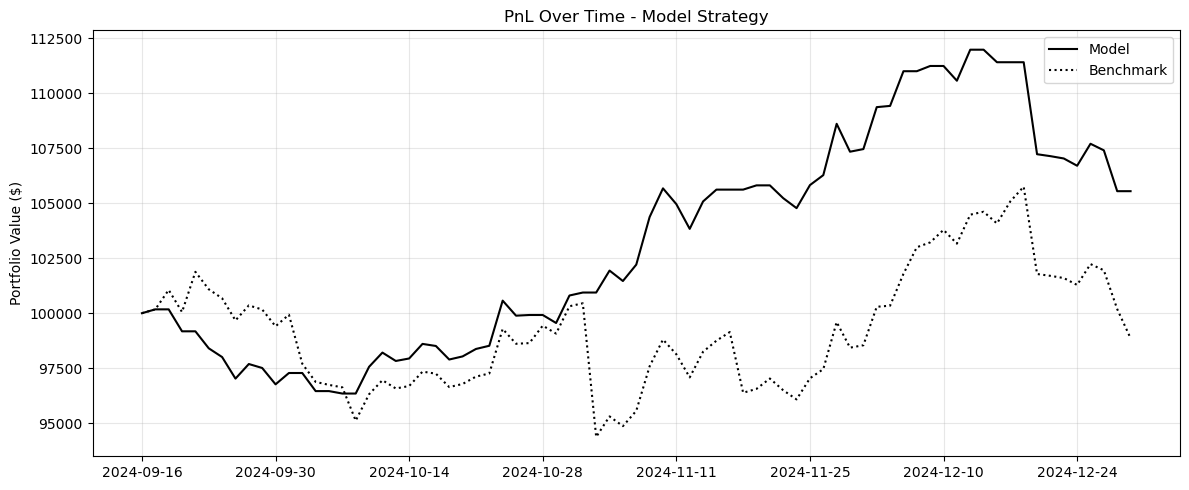

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(joint_df['Date'], joint_df['PnL'], label='Model',color='black')
plt.plot(joint_df['Date'],joint_df['Benchmark PnL'], label='Benchmark', color='black', linestyle=':')
plt.ylabel('Portfolio Value ($)')
plt.title('PnL Over Time - Model Strategy')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.xticks(pnl_df['Date'][::10])
plt.savefig('media/model_vs_benchmark_PnL')
plt.show()

Performance of the model is good! It could likely be improved by feeding more data/engineering more features that are relevant to the prosperity of MSFT. Furthermore, I think it could be improved my moving away from hard labels to soft labels and placing order magnitude based on probability of up or down movement. For example if SVM model gives high probability of classification to up movement we would place more agressive bets whereas if the probability is closer to the boundary our bet would be more conservative to mitigate loss in the event of a down movement.